# Деревья. Случайный лес


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

Напишем и протестируем собственную реализацию решающего дерева.

Реализуйем функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием. В качестве меры хаотичности $H(R)$ для задачи регрессии испольем дисперсию подвыборки, а для задачи классификации – критерий Джини.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое.


In [ ]:
from typing import Union, Tuple

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    X = np.asarray(feature_vector)
    y = np.asarray(target_vector)

    if feature_type == "real":
        sorted_indices = np.argsort(X)
        X_sorted = X[sorted_indices]
        y_sorted = y[sorted_indices]

        unique_vals = np.unique(X_sorted)
        if len(unique_vals) == 1:
            return np.array([]), np.array([]), None, None

        thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

        mask = X_sorted[:, None] <= thresholds
        n = len(y_sorted)
        n_left = mask.sum(axis=0)
        n_right = n - n_left

        if task == "classification":
            classes = np.unique(y)
            y_one_hot = np.equal.outer(y_sorted, classes).astype(int)

            left_counts = mask.T @ y_one_hot
            right_counts = y_one_hot.sum(axis=0) - left_counts

            left_probs = left_counts / n_left[:, None]
            right_probs = right_counts / n_right[:, None]

            gini_left = 1 - np.sum(left_probs ** 2, axis=1)
            gini_right = 1 - np.sum(right_probs ** 2, axis=1)

            ginis = (n_left * gini_left + n_right * gini_right) / n

            best_idx = np.argmin(ginis)
            return thresholds, ginis, thresholds[best_idx], ginis[best_idx]

        elif task == "regression":
            y_cumsum = np.cumsum(y_sorted)
            y_squared_cumsum = np.cumsum(y_sorted ** 2)

            left_sum = y_cumsum[:-1]
            left_sq_sum = y_squared_cumsum[:-1]
            right_sum = y_cumsum[-1] - left_sum
            right_sq_sum = y_squared_cumsum[-1] - left_sq_sum

            n_left = np.arange(1, n)
            n_right = n - n_left

            left_var = left_sq_sum / n_left - (left_sum / n_left) ** 2
            right_var = right_sq_sum / n_right - (right_sum / n_right) ** 2

            var_total = (n_left * left_var + n_right * right_var) / n

            thresholds = (X_sorted[:-1] + X_sorted[1:]) / 2
            mask = X_sorted[1:] != X_sorted[:-1]
            thresholds = thresholds[mask]
            var_total = var_total[mask]

            best_idx = np.argmin(var_total)
            return thresholds, var_total, thresholds[best_idx], var_total[best_idx]

    elif feature_type == "categorical":
        categories = np.unique(X)
        best_gini = float('inf')
        best_cat = None
        results = []

        for cat in categories:
            left_mask = X == cat
            right_mask = ~left_mask

            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue

            if task == "classification":
                def gini(group):
                    _, counts = np.unique(y[group], return_counts=True)
                    probs = counts / counts.sum()
                    return 1 - np.sum(probs ** 2)

                g_left = gini(left_mask)
                g_right = gini(right_mask)
                g_total = (left_mask.sum() * g_left + right_mask.sum() * g_right) / len(y)

            elif task == "regression":
                def var(group):
                    return np.var(y[group])

                g_left = var(left_mask)
                g_right = var(right_mask)
                g_total = (left_mask.sum() * g_left + right_mask.sum() * g_right) / len(y)

            results.append((cat, g_total))
            if g_total < best_gini or (g_total == best_gini and cat < best_cat):
                best_gini = g_total
                best_cat = cat

        thresholds = np.array([cat for cat, _ in results])
        ginis = np.array([g for _, g in results])

        return thresholds, ginis, best_cat, best_gini

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведем график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

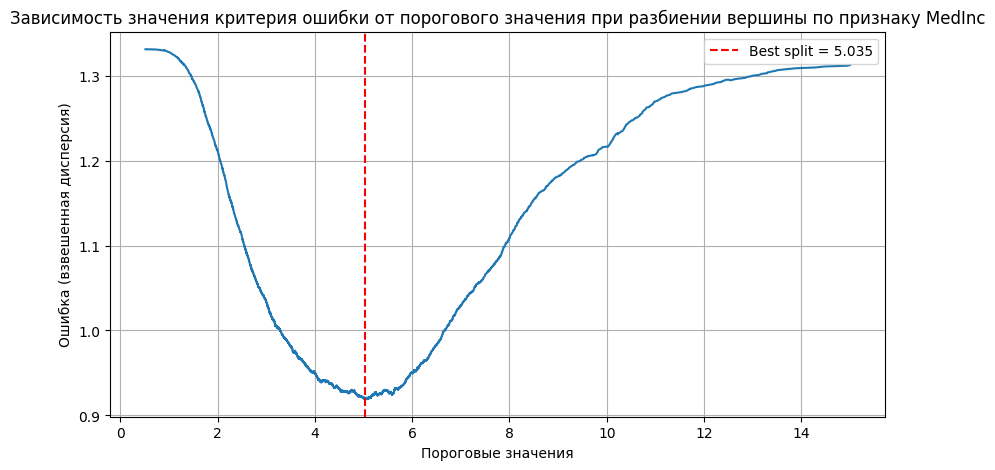

In [ ]:
X_medinc = X['MedInc']
thresholds, errors, threshold_best, error_best = find_best_split(
    X_medinc, y, task="regression", feature_type="real")
plt.figure(figsize=(10, 5))
plt.plot(thresholds, errors)
plt.axvline(threshold_best, color='r', linestyle='--', label=f"Best split = {threshold_best:.3f}")
plt.xlabel('Пороговые значения')
plt.ylabel('Ошибка (взвешенная дисперсия)')
plt.title('Зависимость значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc')
plt.legend()
plt.grid(True);

In [ ]:
print(f"Best threshold: {threshold_best:.3f}")

Best threshold: 5.035


Построение дерева осуществляется согласно базовому жадному алгоритму.
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.


In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
                feature_vector = np.where(np.isnan(feature_vector), np.nanmean(feature_vector), feature_vector) #замена Nan на среднее
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
                mask_not_nan = ~pd.isnull(feature_vector)
                if np.any(mask_not_nan):
                  most_common = Counter(feature_vector[mask_not_nan]).most_common(1)[0][0]
                  feature_vector = np.where(pd.isnull(feature_vector), most_common, feature_vector) #замена на моду

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                self._feature_importances[feature] = self._feature_importances.get(feature, 0) + gini
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
          return node["class"]

        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        if feature_type == "real":
          if x[feature_idx] <= node["threshold"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])

        elif feature_type == "categorical":
          if x[feature_idx] == node["category_split"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

    def get_feature_importances(self):
      total_importance = sum(self._feature_importances.values())
      return {
          feature_idx: importance / total_importance
          for feature_idx, importance in self._feature_importances.items()
      }

Загрузим таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Построим на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
data = pd.read_csv("students.csv")
data = data.drop(columns='Unnamed: 0')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
feature_names = data.columns[:-1].tolist()
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


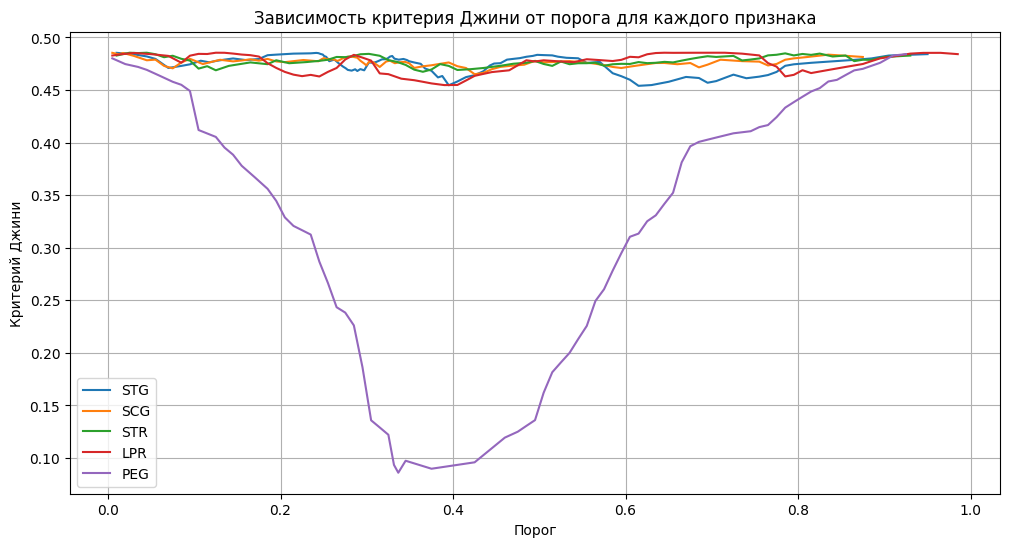

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(X.shape[1]):
    feature_vector = X[:, i]
    thresholds, ginis, _, _ = find_best_split(
        feature_vector=feature_vector,
        target_vector=y,
        task="classification",
        feature_type="real"
    )
    plt.plot(thresholds, ginis, label=feature_names[i])

plt.xlabel("Порог")
plt.ylabel("Критерий Джини")
plt.title("Зависимость критерия Джини от порога для каждого признака")
plt.legend()
plt.grid(True)
plt.show()

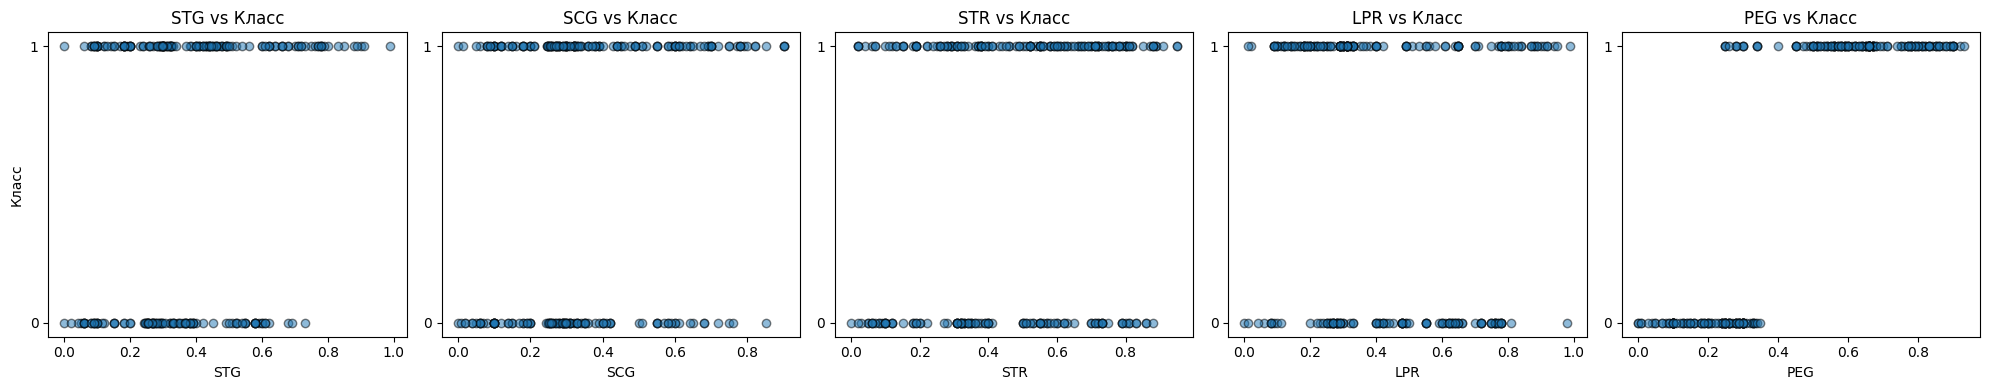

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.scatter(X[:, i], y, alpha=0.5, edgecolor='k')
    ax.set_xlabel(feature_names[i])
    ax.set_title(f"{feature_names[i]} vs Класс")
    ax.set_yticks([0, 1])

axes[0].set_ylabel("Класс")
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини надо производить деление по признаку PEG, тк у него критерий Джини имеет наименьшее значение, на диаграмме рассеевания также хорошо видно разделение классов(1 правее, а 0 левее).\
У хороших признаков кривая Джини имеет четкий минимум, это значит, что можно разделить данные на две части, у признаков, по которым деление практически невозможно, кривые плоские без четко выраженного минимума, а на диаграмме рассеевания не получается визуально разделить точки на две группы.

## Бэггинг и случайный лес

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

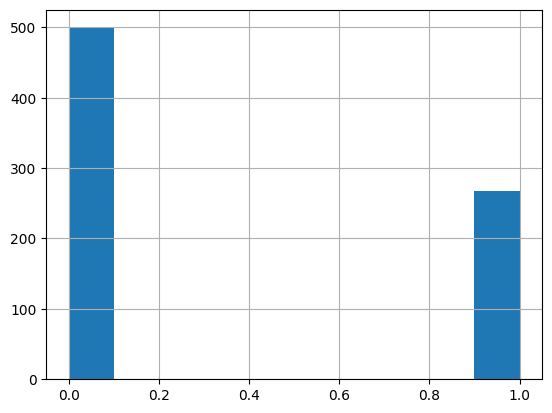

In [ ]:
data['Outcome'].hist()
plt.show()

In [ ]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=42)

На обучающей-валидационной выборке подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`.


Обучим решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

max_depth_list = [3, 5, 7, 10]
min_samples_leaf_list = [1, 2, 5, 10]

best_params = None
best_f1 = -np.inf

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

print("Лучшие гиперпараметры:", best_params)
print("Лучшее значение F1 на валидации:", best_f1)

clf_final = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
clf_final.fit(X_train1, y_train1)


y_test_pred = clf_final.predict(X_test)
y_test_prob = clf_final.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUC ROC: {auc_roc:.3f}")

Лучшие гиперпараметры: {'max_depth': 5, 'min_samples_leaf': 5}
Лучшее значение F1 на валидации: 0.6666666666666666
Accuracy: 0.771
Precision: 0.714
Recall: 0.562
AUC ROC: 0.794


Обучим [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке.

In [ ]:
from sklearn.ensemble import BaggingClassifier

base_clf = DecisionTreeClassifier(random_state=42)

bagging_clf = BaggingClassifier(
    estimator=base_clf,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

bagging_clf.fit(X_train1, y_train1)

y_test_pred = bagging_clf.predict(X_test)
y_test_prob = bagging_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUC ROC: {auc_roc:.3f}")

Accuracy: 0.749
Precision: 0.631
Recall: 0.662
AUC ROC: 0.808


Выполним кросс-валидацию на полной обучающей выборке и подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

best_params = None
best_score = -np.inf
min_samples_split_list = [2, 5, 10]
for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        scores = cross_val_score(rf, X_train1, y_train1, cv=5, scoring='f1', n_jobs=-1)
        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}

print("Лучшие гиперпараметры: ", best_params)
print("Лучшее среднее F1:", best_score)

rf_final = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train1, y_train1)

y_test_pred = rf_final.predict(X_test)
y_test_prob = rf_final.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUC ROC: {auc_roc:.3f}")


Лучшие гиперпараметры:  {'max_depth': 10, 'min_samples_split': 10}
Лучшее среднее F1: 0.627475158236513
Accuracy: 0.749
Precision: 0.634
Recall: 0.650
AUC ROC: 0.817


DecisionTree лучше по точности (Accuracy = 0.771), но хуже находит положительные классы (Recall = 0.562). RandomForest и Bagging имеют высокий Recall (0.650–0.662), т.е. лучше ловят все важные случаи. Также лучший AUC ROC (0.817 у RandomForest), значит он стабильнее разделяет классы и является лучше моделью из этих трех.

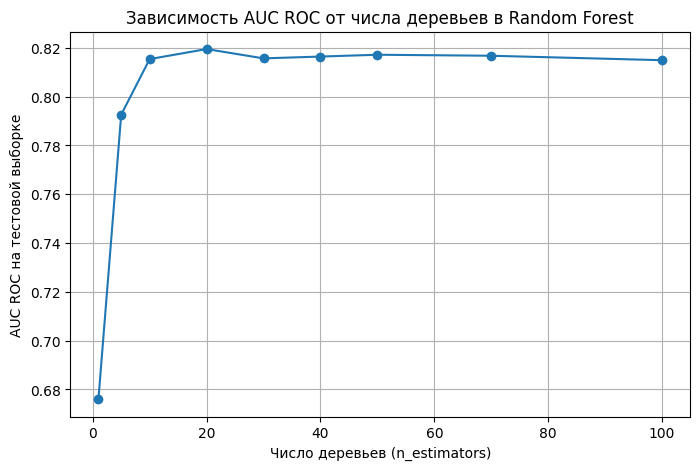

In [ ]:
n_estimators_list = [1, 5, 10, 20, 30, 40, 50, 70, 100]
auc_scores = []

for n in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train1, y_train1)
    y_prob = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, auc_scores, marker='o')
plt.title('Зависимость AUC ROC от числа деревьев в Random Forest')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC на тестовой выборке')
plt.grid(True)
plt.show()

От 0 до 20 числа деревьев AUC ROC растет, а далее начинает убывать, можно сделать вывод, что 20 деревьев - это оптимальное колличество.

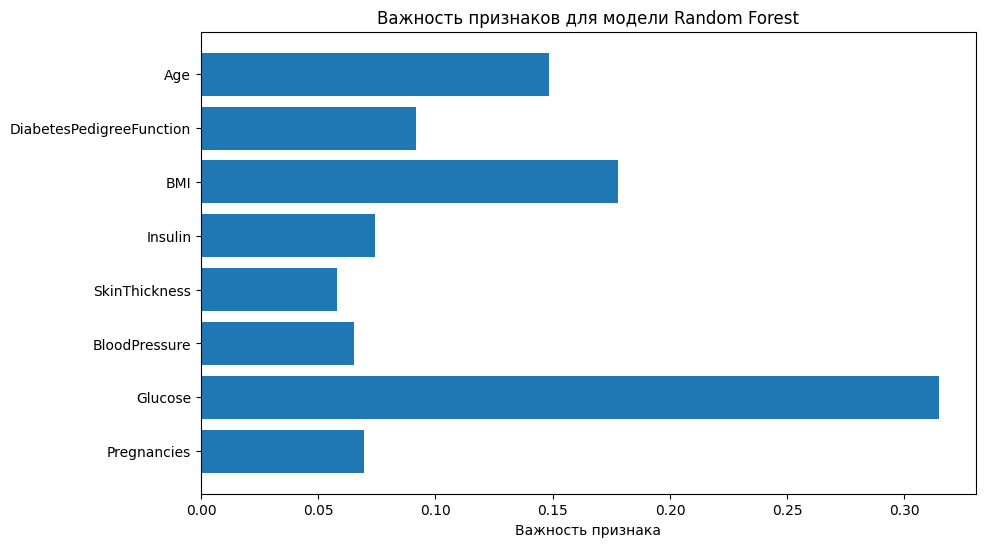

In [ ]:
importances = rf_final.feature_importances_


plt.figure(figsize=(10,6))
plt.barh(X.columns, importances)
plt.xlabel('Важность признака')
plt.title('Важность признаков для модели Random Forest')
plt.show()

Самый важный признак "Glucose", что логично, тк при диабете глюкоза накапливается в крови.